In [1]:
import pandas as pd
import numpy as np
import statsmodels.stats as st
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.pandas.set_option("display.max_columns",None)
%matplotlib inline

In [2]:
data = pd.read_csv("Cleaned_data.csv")

In [3]:
df = data.copy()
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,2.6,9.1,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,7.0,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,8.0,8.1,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,8.0,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,7.8,11.3,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,0.0,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,5.0,12.8,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,1.0,3.0,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,2.6,11.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [4]:
df["Month"] = pd.to_datetime(df["Date"]).dt.month
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,Month
0,2008-12-01,Albury,13.4,22.9,0.6,2.6,9.1,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,7.0,16.9,21.8,No,0.0,No,12
1,2008-12-02,Albury,7.4,25.1,0.0,8.0,8.1,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,8.0,17.2,24.3,No,0.0,No,12
2,2008-12-03,Albury,12.9,25.7,0.0,7.8,11.3,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,0.0,2.0,21.0,23.2,No,0.0,No,12
3,2008-12-04,Albury,9.2,28.0,0.0,5.0,12.8,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,1.0,3.0,18.1,26.5,No,1.0,No,12
4,2008-12-05,Albury,17.5,32.3,1.0,2.6,11.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No,12


In [5]:
df["Month"] = df['Month'].astype('str')

In [6]:
df['Location_y'] = df['Location'] + df['RainTomorrow'].astype("str")
df['Location_y'].head()

0    AlburyNo
1    AlburyNo
2    AlburyNo
3    AlburyNo
4    AlburyNo
Name: Location_y, dtype: object

In [7]:
df['RainToday'] = df['RainToday'].map({'Yes':1,'No':0})
df['RainTomorrow'] = df['RainTomorrow'].map({'Yes':1,'No':0})

In [8]:
df.drop(["RISK_MM","Date"], axis = 1, inplace = True)

In [9]:
X = df.drop('RainTomorrow', axis = 1)
y = df['RainTomorrow']

In [10]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,precision_score,recall_score,f1_score,roc_curve,roc_auc_score

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify = df['Location_y'],test_size = 0.33,random_state=42)

In [12]:
X_train.drop('Location_y', axis = 1, inplace = True)
X_test.drop('Location_y', axis = 1, inplace = True)

In [13]:
print("No. of features before One Hot Encoding: ",X_train.shape[1])
X_train = pd.get_dummies(X_train, drop_first = True)
X_test = pd.get_dummies(X_test, drop_first = True)
print('No. of features after performing One-Hot Encoding: ', X_train.shape[1])

No. of features before One Hot Encoding:  22
No. of features after performing One-Hot Encoding:  121


In [14]:
features = list(X_train.columns)

In [15]:
def fit_model (model, X_train, y_train, X_test, y_test):
    '''Fits the passed model to the train set and 
    generates a detailed classification report with plots'''
    
    model.fit(X_train,y_train)
    
    y_pred = model.predict(X_test)
    
    print("Precision: %0.4f"%precision_score(y_test,y_pred))
    print("Recall:    %0.4f"%recall_score(y_test,y_pred))
    print("F1 Score:  %0.4f"%f1_score(y_test,y_pred))
    print("\n\nCONFUSION MATRIX:\n")
    print(confusion_matrix(y_test,y_pred))
    print("\n\nCLASSIFICATION REPORT\n")
    print(classification_report(y_test,y_pred))
    
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
    
    print("AUC Score: %0.4f"%roc_auc_score(y_test,model.predict_proba(X_test)[:,1]))

In [16]:
rf_base = RandomForestClassifier()

Precision: 0.7735
Recall:    0.4686
F1 Score:  0.5836


CONFUSION MATRIX:

[[34964  1443]
 [ 5589  4928]]


CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.86      0.96      0.91     36407
           1       0.77      0.47      0.58     10517

    accuracy                           0.85     46924
   macro avg       0.82      0.71      0.75     46924
weighted avg       0.84      0.85      0.84     46924



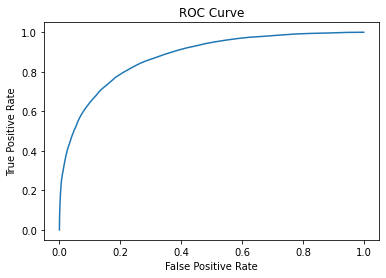

AUC Score: 0.8771


In [17]:
fit_model(rf_base,X_train,y_train,X_test,y_test)

In [18]:
feature_imp = pd.DataFrame()

for (i,j) in zip(features,list(rf_base.feature_importances_)):
    feature_imp = feature_imp.append({'Features':i,'Importance':j}, ignore_index = True)

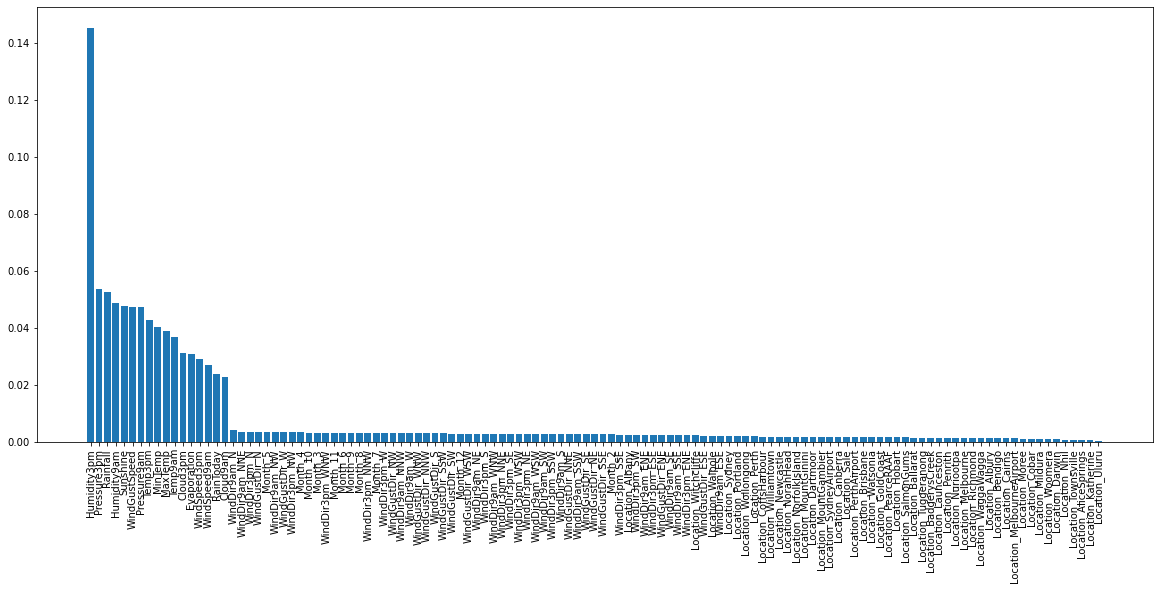

In [19]:
b = feature_imp.sort_values(by='Importance',ascending=False)

plt.figure(figsize=(20,8))
plt.bar(height = b['Importance'], x = b['Features'])
plt.xticks(rotation=90)
plt.show()

We observe a F1 score of 0.59. By looking at the feature importance graph we can say that all the location features are not important for the model having very low feature importance values. Now, let us try to fit one more random forest model without the location feature.

In [20]:
df = data.copy()
df["Month"] = pd.to_datetime(df["Date"]).dt.month
df["Month"] = df['Month'].astype('str')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,Month
0,2008-12-01,Albury,13.4,22.9,0.6,2.6,9.1,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,7.0,16.9,21.8,No,0.0,No,12
1,2008-12-02,Albury,7.4,25.1,0.0,8.0,8.1,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,8.0,17.2,24.3,No,0.0,No,12
2,2008-12-03,Albury,12.9,25.7,0.0,7.8,11.3,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,0.0,2.0,21.0,23.2,No,0.0,No,12
3,2008-12-04,Albury,9.2,28.0,0.0,5.0,12.8,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,1.0,3.0,18.1,26.5,No,1.0,No,12
4,2008-12-05,Albury,17.5,32.3,1.0,2.6,11.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No,12


In [21]:
df.drop(['Date','Location','RISK_MM'], axis = 1, inplace = True)

In [22]:
cat = [i for i in df.select_dtypes("object")]
cat

['WindGustDir',
 'WindDir9am',
 'WindDir3pm',
 'RainToday',
 'RainTomorrow',
 'Month']

In [23]:
df['RainToday'] = df['RainToday'].map({'Yes':1,'No':0})
df['RainTomorrow'] = df['RainTomorrow'].map({'Yes':1,'No':0})

In [24]:
X = df.drop('RainTomorrow',axis = 1)
y = df['RainTomorrow']

In [25]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify = y,test_size = 0.33,random_state=42)

In [26]:
print("No. of features before One Hot Encoding: ",X_train.shape[1])
X_train = pd.get_dummies(X_train, drop_first = True)
X_test = pd.get_dummies(X_test, drop_first = True)
print('No. of features after performing One-Hot Encoding: ', X_train.shape[1])

No. of features before One Hot Encoding:  21
No. of features after performing One-Hot Encoding:  73


In [27]:
features = list(X_train.columns)
X_dummies = X_train.copy()

### Base Model Without the location feature.

In [28]:
rf_base = RandomForestClassifier()

Precision: 0.7735
Recall:    0.4756
F1 Score:  0.5890


CONFUSION MATRIX:

[[34940  1465]
 [ 5516  5003]]


CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.86      0.96      0.91     36405
           1       0.77      0.48      0.59     10519

    accuracy                           0.85     46924
   macro avg       0.82      0.72      0.75     46924
weighted avg       0.84      0.85      0.84     46924



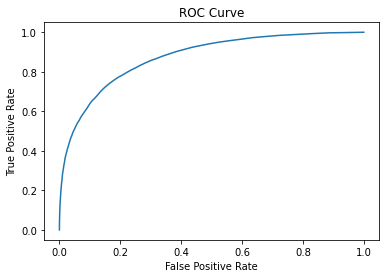

AUC Score: 0.8732


In [29]:
fit_model(rf_base,X_train,y_train,X_test,y_test)

In [30]:
feature_imp = pd.DataFrame()

for (i,j) in zip(features,list(rf_base.feature_importances_)):
    feature_imp = feature_imp.append({'Features':i,'Importance':j}, ignore_index = True)

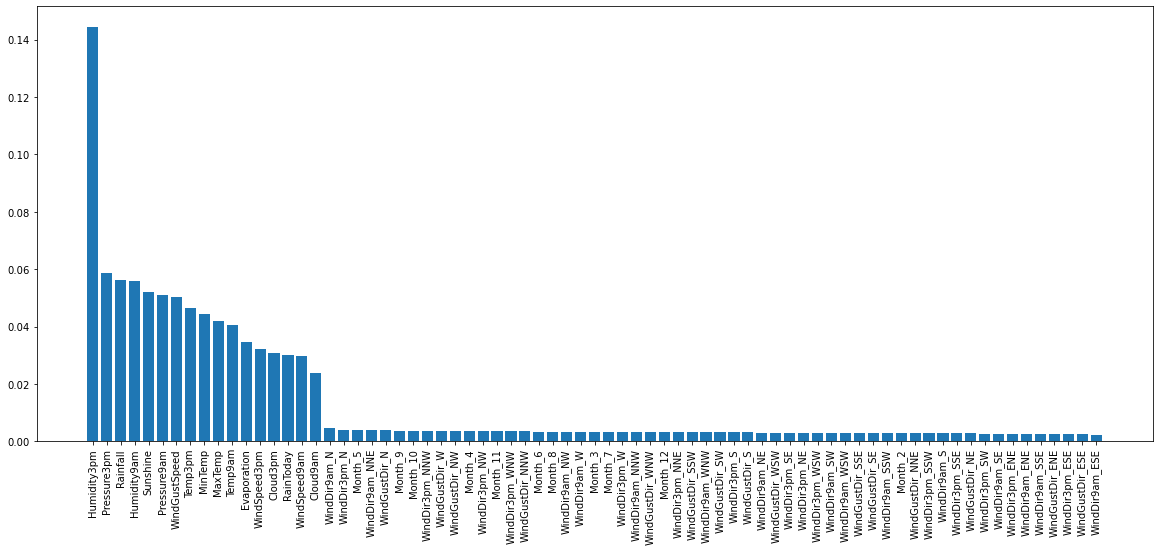

In [31]:
b = feature_imp.sort_values(by='Importance',ascending=False)

plt.figure(figsize=(20,8))
plt.bar(height = b['Importance'], x = b['Features'])
plt.xticks(rotation=90)
plt.show()

We are getting the same score without the location feature. We are also reducing the no. of features of our data from 121 to 73 by deleting the location feature.Now let us try to balance the class of the data by applying some resampling techniques.

In [32]:
from imblearn.over_sampling import RandomOverSampler, SMOTE 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

### 1) Combination of UnderSampling and OverSampling

In [33]:
under = RandomUnderSampler(sampling_strategy=0.5)
over = RandomOverSampler()
pipe = Pipeline([('u',under),('o',over)])

In [34]:
X_train_comb,y_train_comb = pipe.fit_resample(X_train,y_train)

After Using Combination of Oversampling & Undersampling: 

Precision: 0.6186
Recall:    0.6767
F1 Score:  0.6464


CONFUSION MATRIX:

[[32017  4388]
 [ 3401  7118]]


CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.90      0.88      0.89     36405
           1       0.62      0.68      0.65     10519

    accuracy                           0.83     46924
   macro avg       0.76      0.78      0.77     46924
weighted avg       0.84      0.83      0.84     46924



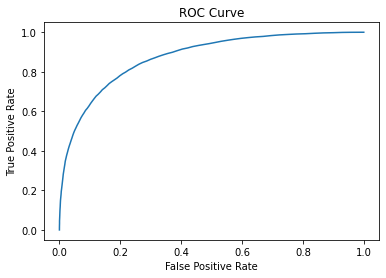

AUC Score: 0.8745


In [35]:
print("After Using Combination of Oversampling & Undersampling: \n")
rf_comb = RandomForestClassifier()
fit_model(rf_comb,X_train_comb,y_train_comb,X_test,y_test)

### 2) SMOTE

In [36]:
smote = SMOTE()

In [37]:
X_train_sm,y_train_sm = smote.fit_resample(X_train,y_train)

After SMOTE Resampling: 

Precision: 0.6906
Recall:    0.5698
F1 Score:  0.6244


CONFUSION MATRIX:

[[33720  2685]
 [ 4525  5994]]


CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.88      0.93      0.90     36405
           1       0.69      0.57      0.62     10519

    accuracy                           0.85     46924
   macro avg       0.79      0.75      0.76     46924
weighted avg       0.84      0.85      0.84     46924



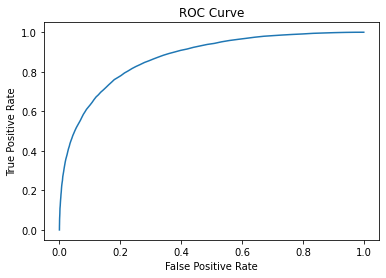

AUC Score: 0.8725


In [38]:
print("After SMOTE Resampling: \n")
rf_smote = RandomForestClassifier()
fit_model(rf_smote,X_train_sm,y_train_sm,X_test,y_test)

We are getting a F1 score of 0.65 by balancing the class using the combination of oversampling and undersampling as compared to the F1 score of 0.63 using SMOTE.

## Feature Selection

### 1) Recursive Feature Elimination

In [39]:
from sklearn.feature_selection import RFE
rfe = RFE(RandomForestClassifier())

In [40]:
X_train_rfe = rfe.fit_transform(X_train_comb,y_train_comb)
X_test_rfe = rfe.transform(X_test)

In [41]:
print("No. of features before appling RFE: ",X_train.shape[1])
print("No. of features after appling RFE: ",rfe.n_features_)

No. of features before appling RFE:  73
No. of features after appling RFE:  36


In [42]:
selected_features = np.ravel(np.where(rfe.support_))

print("The Selected Features are: \n")
for i in selected_features:
    print(features[i])

The Selected Features are: 

MinTemp
MaxTemp
Rainfall
Evaporation
Sunshine
WindGustSpeed
WindSpeed9am
WindSpeed3pm
Humidity9am
Humidity3pm
Pressure9am
Pressure3pm
Cloud9am
Cloud3pm
Temp9am
Temp3pm
RainToday
WindGustDir_N
WindGustDir_NW
WindGustDir_S
WindGustDir_W
WindDir9am_N
WindDir9am_NNE
WindDir9am_W
WindDir3pm_N
WindDir3pm_NE
WindDir3pm_NNW
WindDir3pm_NW
WindDir3pm_WNW
Month_10
Month_11
Month_12
Month_3
Month_4
Month_5
Month_9


Precision: 0.6172
Recall:    0.6697
F1 Score:  0.6424


CONFUSION MATRIX:

[[32036  4369]
 [ 3474  7045]]


CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.90      0.88      0.89     36405
           1       0.62      0.67      0.64     10519

    accuracy                           0.83     46924
   macro avg       0.76      0.77      0.77     46924
weighted avg       0.84      0.83      0.84     46924



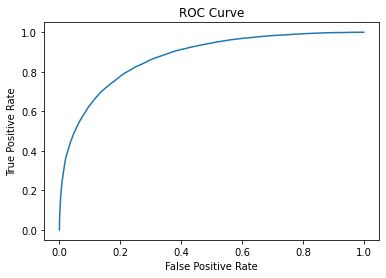

AUC Score: 0.8732


In [43]:
rf_comb_rfe = RandomForestClassifier()
fit_model(rf_comb_rfe,X_train_rfe,y_train_comb,X_test_rfe,y_test)

In [44]:
extracted = []

for i in selected_features:
    extracted.append(features[i])

In [45]:
comb_rfe_coeff = np.ravel(rf_comb_rfe.feature_importances_)

feature_importance_rfe = pd.DataFrame(columns = ['Features','Importance'])

for (i,j) in zip(extracted,comb_rfe_coeff):
    feature_importance_rfe = feature_importance_rfe.append({'Features':i,'Importance':j}, ignore_index = True)

In [46]:
feature_importance_rfe = feature_importance_rfe.set_index(feature_importance_rfe['Features'])
feature_importance_rfe.drop('Features', axis = 1, inplace = True)
feature_importance_rfe = feature_importance_rfe.sort_values(by = 'Importance',ascending = False)

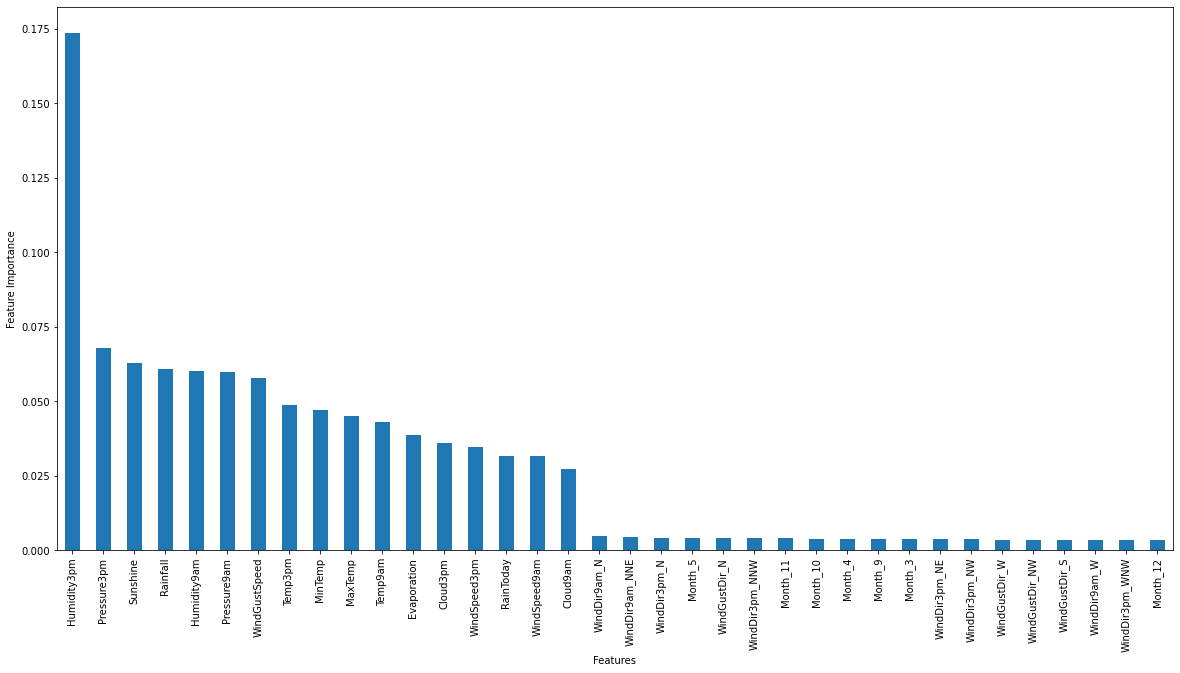

In [47]:
feature_importance_rfe['Importance'].sort_values(ascending = False).plot(kind = 'bar',figsize = (20,10))
plt.ylabel("Feature Importance")
plt.show()

## HYPERTUNING THE PARAMETERS

In [48]:
#from sklearn.model_selection import GridSearchCV

In [49]:
"""pipe_smote = Pipeline([['u',RandomUnderSampler(sampling_strategy=0.5)],('o',RandomOverSampler()),('rf',RandomForestClassifier())])
params = {'o__sampling_strategy':(0.5,0.75,1)
         ,'rf__n_estimators':(50,100,200,300)
         ,'rf_max_depth'}
gcv = GridSearchCV(pipe, param_grid = params, cv = 3, scoring = 'f1', n_jobs = -1)"""

"pipe_smote = Pipeline([['u',RandomUnderSampler(sampling_strategy=0.5)],('o',RandomOverSampler()),('rf',RandomForestClassifier())])\nparams = {'o__sampling_strategy':(0.5,0.75,1)\n         ,'rf__n_estimators':(50,100,200,300)\n         ,'rf_max_depth'}\ngcv = GridSearchCV(pipe, param_grid = params, cv = 3, scoring = 'f1', n_jobs = -1)"

In [50]:
#gcv.fit(X_train_rfe, y_train_comb)

In [51]:
#gcv.best_estimator_

In [52]:
#rf_gcv = fit_model(RandomForestClassifier(),X_train_new,y_train_new,X_test_gcv,y_test)

In [53]:
"""coeff_gcv = pd.DataFrame()

for (i,j) in zip(extracted,list(np.ravel(rf_gcv.coef_))):
    coeff_gcv = coeff_gcv.append({'Features':i,'rf_gcv_coeff':j}, ignore_index = True)"""

"coeff_gcv = pd.DataFrame()\n\nfor (i,j) in zip(extracted,list(np.ravel(rf_gcv.coef_))):\n    coeff_gcv = coeff_gcv.append({'Features':i,'rf_gcv_coeff':j}, ignore_index = True)"

In [54]:
"""x = coeff_gcv.sort_values(by='rf_gcv_coeff',ascending=False)

plt.figure(figsize=(20,8))
plt.bar(height = x['rf_gcv_coeff'], x = x['Features'])
plt.xticks(rotation=90)
plt.show()"""

"x = coeff_gcv.sort_values(by='rf_gcv_coeff',ascending=False)\n\nplt.figure(figsize=(20,8))\nplt.bar(height = x['rf_gcv_coeff'], x = x['Features'])\nplt.xticks(rotation=90)\nplt.show()"